# Credit Card Fraud Prediction 

In [110]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge, Lasso 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import chi2
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import ensemble
from sklearn.svm import SVC

%matplotlib inline
sns.set_style('white')
import warnings
warnings.filterwarnings("ignore")

## The Data

The datasets contains transactions that occured in two days in September 2013 by european cardholders. The data contains 31 columns, most of which are tranformed principal components, and 284,807 rows among which the fraud class is only 492 (0.172%).

The only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

The dataset can be downloaded on the following link 
https://www.kaggle.com/mlg-ulb/creditcardfraud/home 

In [2]:
# This is how the data frame looks 
creditcard = pd.read_csv('creditcard.csv')
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# a lor of records
creditcard.shape

(284807, 31)

According to the data description, features V1, V2,...V28 are Principal components, and as a result we can assume that they are transformations of the original features. On the othe hand, features 'Time', and 'Amount' are not principal components. Here we will transform them before using them. 

In [4]:
# Transform Amount and Time features and 
creditcard['Amount_tra'] = StandardScaler().fit_transform(creditcard['Amount'].values.reshape(-1,1))
creditcard['Time_tra'] = StandardScaler().fit_transform(creditcard['Time'].values.reshape(-1,1))

#Let's keep only the transformed versions 
creditcard.drop(['Time','Amount'], axis=1, inplace=True)


### Dealing with imbalance data

The classifier algorithms that we are going to use for this prediction may have a bias towards classes  when faced with highly imbalance datasets like this one. They might only predict the majority class in the data. To avoid a possible misclassification, we will resample the data by downsampling the majority class which in our case is the non fraudulant transactions. 

Downsampling helps reduce runtime and storage issues but it could discard useful information. The sample created may also be biased.

In [5]:
# count of each class 
creditcard['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

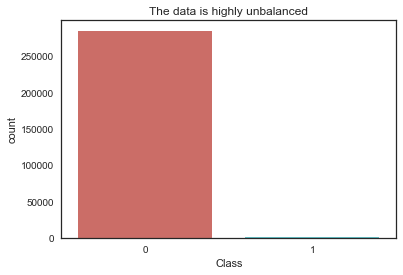

In [6]:
# A plot makes the difference more ovious
sns.countplot(x='Class', data=creditcard, palette='hls')
plt.title('The data is highly unbalanced')
plt.show()

1    492
0    492
Name: Class, dtype: int64
We now have a sample with balanced class


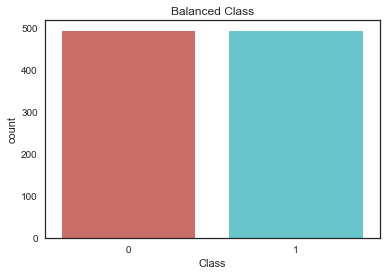

In [7]:
#Import module and resampling 

from sklearn.utils import resample

# Separate majority and minority classes
creditcard_majority = creditcard[creditcard.Class==0]
creditcard_minority = creditcard[creditcard.Class==1]
 
# Downsample majority class
creditcard_majority_downsampled = resample(creditcard_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=492,     # len(creditcard_minority)
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
creditcard_resampled = pd.concat([creditcard_majority_downsampled, creditcard_minority])
 
# Display new class counts
print(creditcard_resampled.Class.value_counts())
print('We now have a sample with balanced class')

sns.countplot(x='Class', data=creditcard_resampled, palette='hls')
plt.title('Balanced Class')
plt.show()

In [8]:
creditcard_resampled.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Amount_tra,Time_tra
143480,-1.337885,0.261692,2.646536,-1.973014,-0.933318,-1.123839,0.277759,-0.039386,1.111226,-1.609648,...,1.124621,-0.312253,0.968527,0.570910,-0.704900,0.253527,0.169347,0,-0.062808,-0.198657
163666,2.081591,-0.774080,-0.674991,-0.322871,-0.890005,-0.801469,-0.532596,-0.280944,-0.354142,0.799470,...,-0.310603,0.268725,0.020092,-0.359343,0.555034,-0.025385,-0.044868,0,-0.212137,0.449021
137005,-0.332971,1.188389,1.308248,0.052384,0.087272,-0.966515,0.750302,-0.108085,-0.488491,-0.528325,...,-0.638700,-0.029226,0.346024,-0.140051,0.070181,0.250678,0.099306,0,-0.349271,-0.270339
155649,-0.830622,1.222904,1.859594,-0.318554,0.272904,0.080357,0.385614,-0.167806,1.502836,-1.045793,...,-0.528849,-0.360037,-0.740677,0.367026,-0.700618,-0.323105,0.064605,0,-0.344753,0.235704
219246,1.964854,0.306862,-2.347355,1.144732,1.453977,-0.144400,0.871268,-0.209065,-0.308091,0.253584,...,1.461507,-0.126488,-0.910153,0.646694,-0.101542,0.000524,-0.089904,0,-0.349231,0.986272


### Correlation 
Since the features are already transformed we may not be able to perform a thorough exploration of the data but, the heatmap of gives as a better understanding of our data and whether the correlation between the features meets the assumptions for the different models that we will use.  

The dataset showed low collinearity before we resample it to balance the classes as shown in the first plot below.

The resampled dataset looks to exhibit high collinearity among some of the features. There are also some negative correlations. Let's examine the correlated features closely.

Text(0.5,1,'Heatmap of the whole dataset')

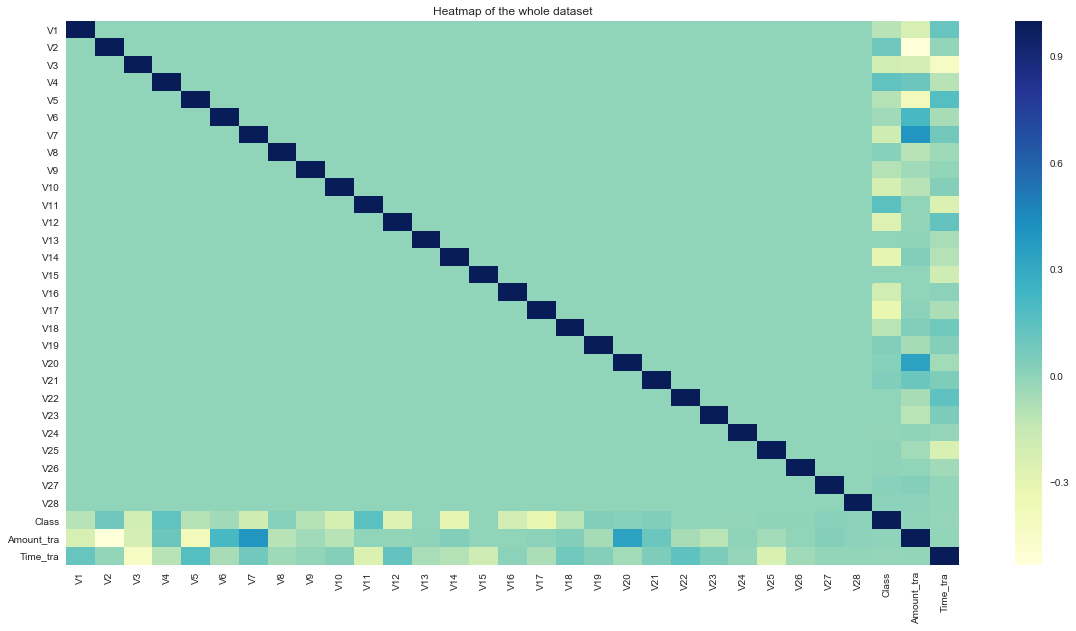

In [9]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(creditcard.corr(), ax=ax, cmap="YlGnBu")
ax.set_title('Heatmap of the whole dataset')

Text(0.5,1,'Heatmap of the resampled dataset')

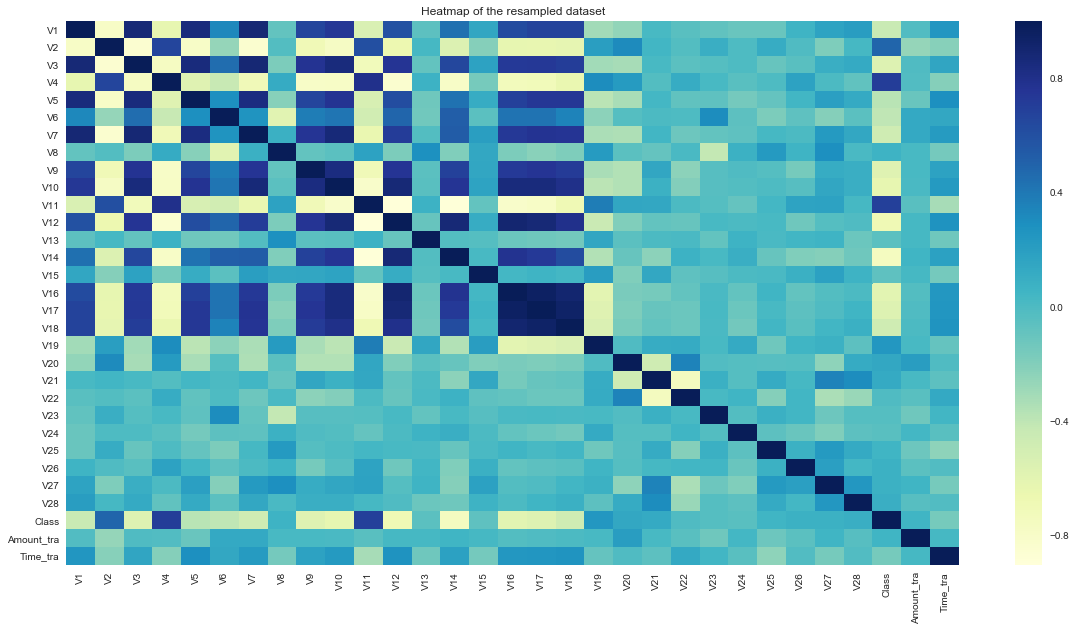

In [10]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(creditcard_resampled.corr(), ax=ax, cmap="YlGnBu")
ax.set_title('Heatmap of the resampled dataset')

Let's now examine the correlated features by visualizing them with a box plot. 

In [11]:
# group the feature together for ease 
components = ['V1', 'V3', 'V5', 'V7', 'V9', 'V10', 'V12', 'V14', 'V16', 'V17', 'V18']


Text(0.5,1,'Removing some of the extream outliers might improve our data')

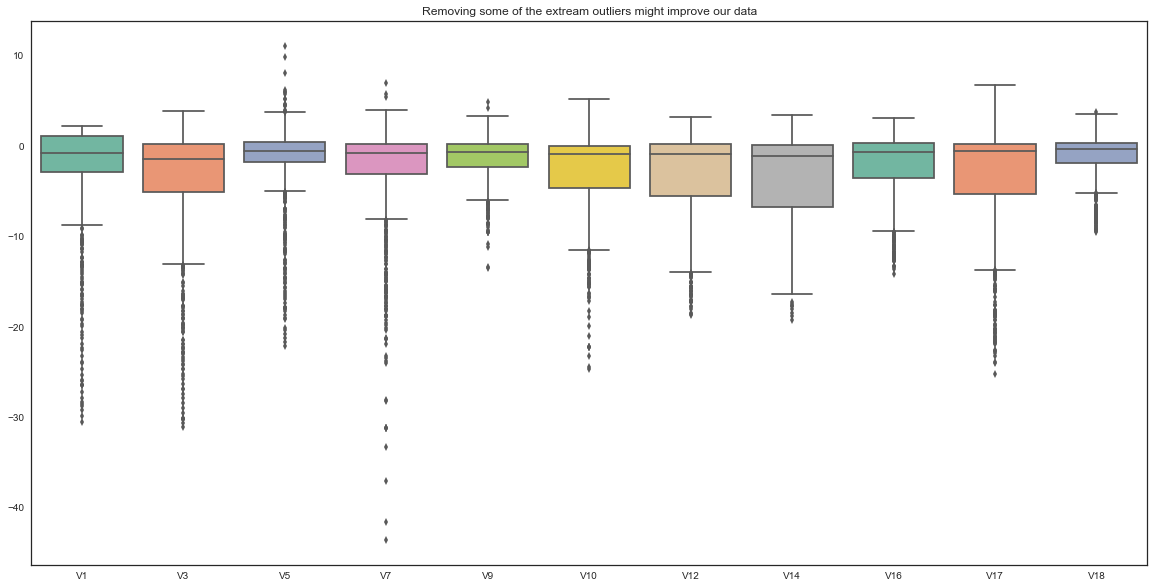

In [12]:
# boxplot for each correlated feature  
fig, ax1 = plt.subplots(figsize=(20,10))
ax1 = sns.boxplot(data=creditcard_resampled[components], orient="v", palette="Set2")
ax1.set_title('Removing some of the extream outliers might improve our data')

The features we identified have a considerable amount of outliers and we will remove outliers above the 85% percentile nad below the 15% percentile. This will create some NaN values and we will replace them with the average value for each feature.  

In [13]:
# Remove outliers
creditcard_resampled[components] = creditcard_resampled[components][((creditcard_resampled[components] > creditcard_resampled[components].quantile(.15))
                                                                     & (creditcard_resampled[components] < creditcard_resampled[components].quantile(.85)))]

In [14]:
# Check for outliers
creditcard_resampled[components].isnull().sum()

V1     296
V3     296
V5     296
V7     296
V9     296
V10    296
V12    296
V14    296
V16    296
V17    296
V18    296
dtype: int64

In [15]:
# The mean is a good measure of central tendency and can be used to replace NaN 
creditcard_resampled[components] = creditcard_resampled[components].fillna(creditcard_resampled[components].mean())

We still see some outliers but the range of the component values is now reduced and the outliers should have a smaller effect on the outcome. Removing outliers comes at a cost of information loss and what we have here looks like a good tradeoff. As the heatmap below shows, we have managed to reduce the collinearity of features in our resampled dataset. 

Text(0.5,1,'The outliers are now taken care of')

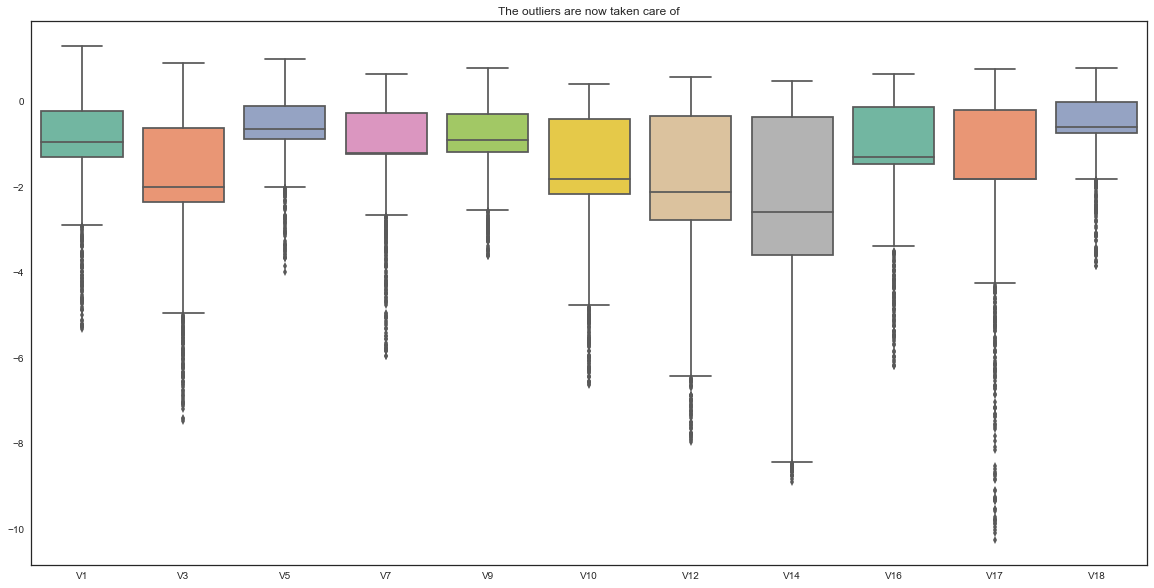

In [19]:
# Still some outliers 
fig, ax1 = plt.subplots(figsize=(20,10))
ax1 = sns.boxplot(data=creditcard_resampled[components], orient="v", palette="Set2")
ax1.set_title('The outliers are now taken care of')

Text(0.5,1,'Heatmap of the resampled dataset after outlier removal')

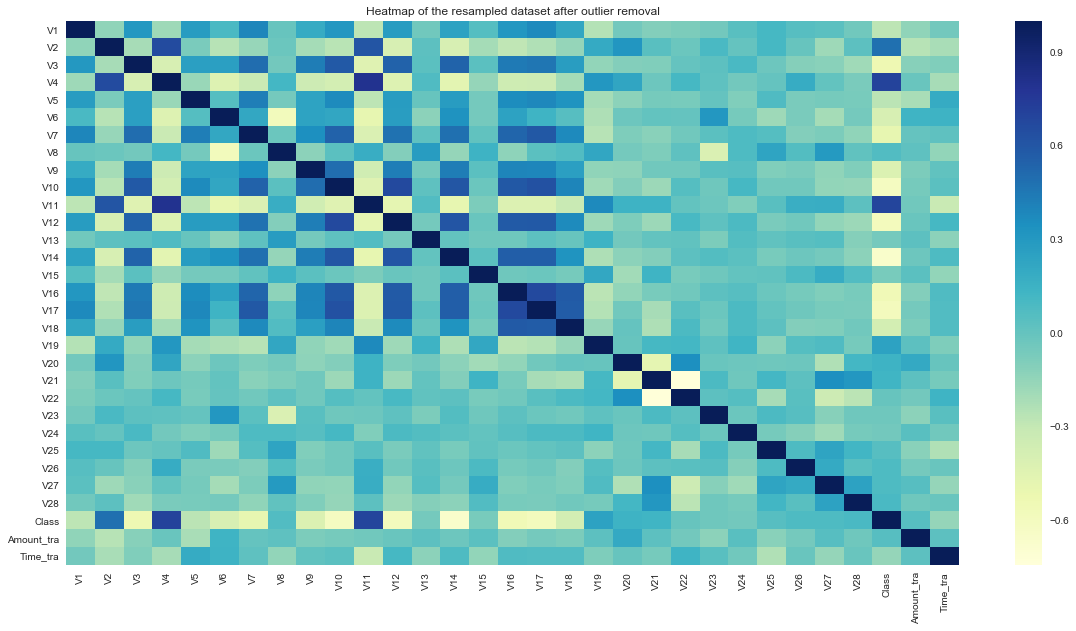

In [21]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(creditcard_resampled.corr(), ax=ax, cmap="YlGnBu")
ax.set_title('Heatmap of the resampled dataset after outlier removal')

Before we start using classifiers, let's store our final dataset as 'trans' for ease of use. And also define our target variable and predictors. 

In [28]:
# Final data to work with 
trans = creditcard_resampled

X = trans.drop('Class', 1)
Y = trans['Class']

## Pridicting fraud using classifiers 

### 1. Naive_Bayes classifier

In [120]:
# Use a 20% holdout group
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [121]:
# Fit the model 
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
y_Naive = bnb.predict(X_test)

In [122]:
# Cross validation score
score = cross_val_score(bnb, X, Y, cv=5)
print(score)

#Confusion matrix 
print('Confusion matrix')
print(confusion_matrix(y_test, y_Naive))


[0.91919192 0.91414141 0.85714286 0.90306122 0.84693878]
Confusion matrix
[[89  6]
 [23 79]]


Among the 197 test points 173 are correctly identified and 24 are incorectly identified. 102 transactions (20 + 86) were identified as fraud though the 20 predictions are false negatives. The cross validation also shows an accuracy in the region of 90%. The model has failed to identify 23 of the fraud transactions correctly (False negatives) 

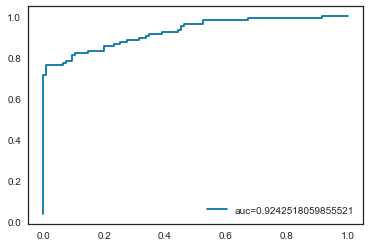

In [123]:
# AUC 
y_pred_proba = bnb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label='auc='+str(auc))
plt.legend(loc=4)
plt.show()

AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

The classification report below shows the model was able to predict fraud with an 85% accuracy. 

In [124]:
# Classification report 
print(classification_report(y_test, y_Naive))

             precision    recall  f1-score   support

          0       0.79      0.94      0.86        95
          1       0.93      0.77      0.84       102

avg / total       0.86      0.85      0.85       197



### 2. KNN classifier 

In [125]:
# Fit the data to knn model 
neigh = KNeighborsClassifier(n_neighbors=20, weights='distance')
neigh.fit(X_train, y_train)
y_knn = neigh.predict(X_test)

#
score_knn = cross_val_score(neigh, X, Y, cv=5)
print(score_knn)

[0.95454545 0.92929293 0.86734694 0.94387755 0.90816327]


In [126]:
#Confusion matrix for knn classifier
print('Confusion matrix')
print(confusion_matrix(y_test, y_knn))

Confusion matrix
[[95  0]
 [18 84]]


The KNN classifier was able to identify 106 of the test data points as fraud transactions among which 84 were true predictions and 18 were mis identified. 

In [127]:
# Classification report 
print(classification_report(y_test, y_knn))

             precision    recall  f1-score   support

          0       0.84      1.00      0.91        95
          1       1.00      0.82      0.90       102

avg / total       0.92      0.91      0.91       197



The classifier identified fraud transactions with a 91% accuracy. (remember that we coded fraud as 1 and non fraud as 0 in our data set)

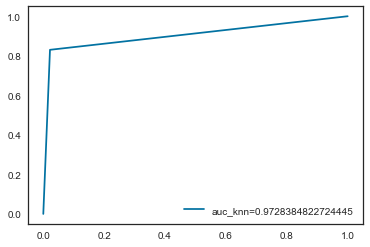

In [53]:
# AUC for knn classifier
y_knn_proba = neigh.predict_proba(X_test)[::,1]
fpr_knn, tpr_knn, _ = metrics.roc_curve(y_test,  y_knn)
auc_knn = metrics.roc_auc_score(y_test, y_knn_proba)
plt.plot(fpr_knn,tpr_knn,label='auc_knn='+str(auc_knn))
plt.legend(loc=4)
plt.show()

## 3. Decision tree classifier 

In [128]:
# Decision tree using GridSearchCV parameters

tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
tree = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5)
grid_fit = tree.fit(X_train, y_train)

best_tree = grid_fit.best_estimator_
y_tree = best_tree.predict(X_test)

[0.7020202  0.88888889 0.85204082 0.92857143 0.90816327]
Confusion matrix
[[91  4]
 [16 86]]
             precision    recall  f1-score   support

          0       0.85      0.96      0.90        95
          1       0.96      0.84      0.90       102

avg / total       0.90      0.90      0.90       197



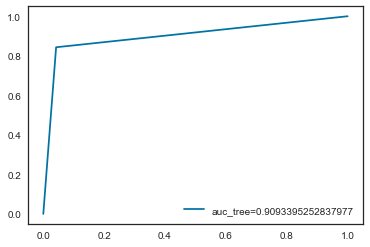

In [129]:
# Evaluations
score_tree = cross_val_score(tree, X, Y, cv=5)
print(score_tree)

#Confusion matrix for decision tree
print('Confusion matrix')
print(confusion_matrix(y_test, y_tree))

# Classification report 
print(classification_report(y_test, y_tree))

# AUC for decision tree classifier
y_tree_proba = tree.predict_proba(X_test)[::,1]
fpr_tree, tpr_tree, _ = metrics.roc_curve(y_test,  y_tree)
auc_tree = metrics.roc_auc_score(y_test, y_tree_proba)
plt.plot(fpr_tree,tpr_tree,label='auc_tree='+str(auc_tree))
plt.legend(loc=4)
plt.show()

The cross validation score shows fluctuations suggesting overfitting or other issue. 102 of the transactions from the test set are identified as fraud. The model was able to predict fraud with an 90% accuracy which is lower than the two models we saw earlier. The model has failed to identify 16 of the fraud transactions correctly (False negatives) 

### 4. Random forest classifier 

In [73]:
forest_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150, 200, 300]}
forest = GridSearchCV(ensemble.RandomForestClassifier(), forest_para, cv=5)
grid_fit_forest = forest.fit(X_train, y_train)

best_forest = grid_fit_forest.best_estimator_
y_forest = best_forest.predict(X_test)

[0.94949495 0.93434343 0.89285714 0.94387755 0.91326531]
Confusion matrix
[[88  3]
 [14 92]]
             precision    recall  f1-score   support

          0       0.86      0.97      0.91        91
          1       0.97      0.87      0.92       106

avg / total       0.92      0.91      0.91       197



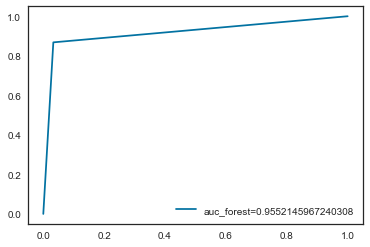

In [74]:
# Evaluations
score_forest = cross_val_score(forest, X, Y, cv=5)
print(score_forest)

#Confusion matrix for random forest
print('Confusion matrix')
print(confusion_matrix(y_test, y_forest))

# Classification report 
print(classification_report(y_test, y_forest))

# AUC for random forest classifier
y_forest_proba = forest.predict_proba(X_test)[::,1]
fpr_forest, tpr_forest, _ = metrics.roc_curve(y_test,  y_forest)
auc_forest = metrics.roc_auc_score(y_test, y_forest_proba)
plt.plot(fpr_forest,tpr_forest,label='auc_forest='+str(auc_forest))
plt.legend(loc=4)
plt.show()

The cross validation score shows more consistency and high accuracy than the decision tree classifier. 106 of the transactions from the test set are identified as fraud. The model was able to predict fraud with a 91% accuracy which is am improvement from the decision tree algorithm and the other models we saw so far. The model has failed to identify 14 of the fraud transactions correctly (False negatives) 

### 5. Logistics regression 

In [80]:
# Binary classification using logistics regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predict using the test set
y_logreg = logreg.predict(X_test)
# Ten fold cross validation score to evaluate the model 
score_logreg = cross_val_score(logreg, X, Y, cv=5)
print(score_logreg)

[0.94444444 0.92929293 0.8877551  0.93877551 0.89285714]


[0.94444444 0.92929293 0.8877551  0.93877551 0.89285714]
Confusion matrix
[[87  4]
 [10 96]]
             precision    recall  f1-score   support

          0       0.90      0.96      0.93        91
          1       0.96      0.91      0.93       106

avg / total       0.93      0.93      0.93       197



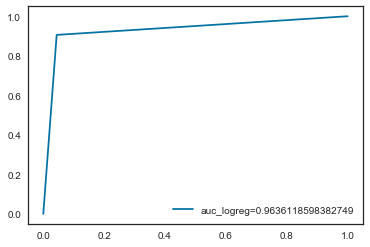

In [85]:
# Evaluations
score_logreg = cross_val_score(logreg, X, Y, cv=5)
print(score_logreg)

#Confusion matrix for logistics regression classifier
print('Confusion matrix')
print(confusion_matrix(y_test, y_logreg))

# Classification report 
print(classification_report(y_test, y_logreg))

# AUC classifier
y_logreg_proba = logreg.predict_proba(X_test)[::,1]
fpr_logreg, tpr_logreg, _ = metrics.roc_curve(y_test,  y_logreg)
auc_logreg = metrics.roc_auc_score(y_test, y_logreg_proba)
plt.plot(fpr_logreg,tpr_logreg,label='auc_logreg='+str(auc_logreg))
plt.legend(loc=4)
plt.show()

The cross validation score shows more consistency and high accuracy than the previous classifiers. 106 of the transactions from the test set are identified as fraud. The model was able to predict fraud with a 93% accuracy which is an improvement from the decision tree algorithm and the other models we saw so far. The model has failed to identify 10 of the fraud transactions correctly (False negatives) 

### 6. Ridge logistics classifier 

In [103]:
# Ridge classifier
ridge = RidgeClassifier()
ridge.fit(X_train, y_train)

y_ridge = ridge.predict(X_test)


In [130]:
# Evaluations
score_ridge = cross_val_score(ridge, X, Y, cv=5)
print(score_ridge)

#Confusion matrix for logistics regression classifier
print('Confusion matrix')
print(confusion_matrix(y_test, y_ridge))

# Classification report 
print(classification_report(y_test, y_ridge))


[0.94949495 0.93434343 0.89285714 0.95408163 0.90306122]
Confusion matrix
[[52 43]
 [52 50]]
             precision    recall  f1-score   support

          0       0.50      0.55      0.52        95
          1       0.54      0.49      0.51       102

avg / total       0.52      0.52      0.52       197



The cross validation score shows consistent and highly accurate result similar to the previous ones. Again, 106 of the transactions from the test set are identified as fraud. The model was able to predict fraud with a 91% accuracy. The model has failed to identify 52 of the fraud transactions correctly (False negatives)  

### 7. Lasso regression

We'll use ordinary logistics regression with 'L1' penality

In [107]:
lasso = LogisticRegression(penalty='l1')
lasso.fit(X_train, y_train)

y_lasso = lasso.predict(X_test)

[0.94444444 0.92929293 0.8877551  0.93367347 0.89285714]
Confusion matrix
[[87  4]
 [10 96]]
             precision    recall  f1-score   support

          0       0.90      0.96      0.93        91
          1       0.96      0.91      0.93       106

avg / total       0.93      0.93      0.93       197



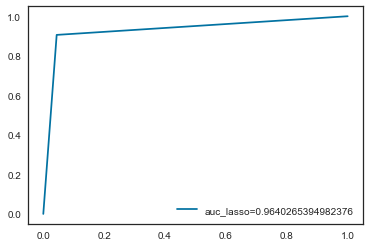

In [108]:
# Evaluations
score_lasso = cross_val_score(lasso, X, Y, cv=5)
print(score_lasso)

#Confusion matrix for logistics regression classifier
print('Confusion matrix')
print(confusion_matrix(y_test, y_lasso))

# Classification report 
print(classification_report(y_test, y_lasso))

# AUC
y_lasso_proba = lasso.predict_proba(X_test)[::,1]
fpr_lasso, tpr_lasso, _ = metrics.roc_curve(y_test,  y_lasso)
auc_lasso = metrics.roc_auc_score(y_test, y_lasso_proba)
plt.plot(fpr_lasso,tpr_lasso,label='auc_lasso='+str(auc_lasso))
plt.legend(loc=4)
plt.show()

The cross validation score shows a score of about 90% similar to the previous ones. Again, 106 of the transactions from the test set are identified as fraud. The model was able to predict fraud with a 93% accuracy. The model has failed to identify 10 of the fraud transactions correctly (False negatives)  

### 8. Support Vector Machine (SVM)

In [131]:
# Set the parameters by cross-validation
# reference http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['rbf'], 'C': [1, 10, 100, 1000]}]
clf = GridSearchCV(SVC(probability=True), tuned_parameters, cv=5)
clf.fit(X_train, y_train)

clf.best_params_

#best_forest = grid_fit_forest.best_estimator_
y_svc = clf.predict(X_test)

[0.94949495 0.93434343 0.90306122 0.93877551 0.92346939]
Confusion matrix
[[93  2]
 [16 86]]
             precision    recall  f1-score   support

          0       0.85      0.98      0.91        95
          1       0.98      0.84      0.91       102

avg / total       0.92      0.91      0.91       197



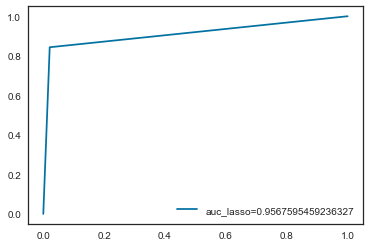

In [132]:
# Evaluations
score_svc = cross_val_score(clf, X, Y, cv=5)
print(score_svc)

#Confusion matrix for logistics regression classifier
print('Confusion matrix')
print(confusion_matrix(y_test, y_svc))

# Classification report 
print(classification_report(y_test, y_svc))

# AUC
y_svc_proba = clf.predict_proba(X_test)[::,1]
fpr_clf, tpr_clf, _ = metrics.roc_curve(y_test,  y_svc)
auc_svc = metrics.roc_auc_score(y_test, y_svc_proba)
plt.plot(fpr_clf,tpr_clf,label='auc_lasso='+str(auc_svc))
plt.legend(loc=4)
plt.show()

This model has the best cross validation score so far all values are above 90%. Again, 102 of the transactions from the test set are identified as fraud. The model was able to predict fraud with a 91% accuracy. The model has failed to identify 16 of the fraud transactions correctly (False negatives) 

In [137]:
#train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(new_features, target, random_state=42,train_size=0.1 )
# We'll make 500 iterations, use gridsearch to tune parameters.
gb_grid_params = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6, 8],
              'min_samples_leaf': [20, 50,100,150],
              #'max_features': [1.0, 0.3, 0.1] 
              }
print(gb_grid_params)

gb_gs = ensemble.GradientBoostingClassifier(n_estimators = 500)

gb_clf = GridSearchCV(gb_gs,
                   gb_grid_params,
                   cv=2,
                   scoring='roc_auc',
                   verbose = 3,
                   n_jobs=10);
gb_clf.fit(X_train, y_train)
predict_train = gb_clf.predict(X_train)
predict_test = gb_clf.predict(X_test)

{'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth': [4, 6, 8], 'min_samples_leaf': [20, 50, 100, 150]}
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    7.8s
[Parallel(n_jobs=10)]: Done  96 out of  96 | elapsed:   23.2s finished


Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done  96 out of  96 | elapsed:   22.4s finished


Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    7.8s
[Parallel(n_jobs=10)]: Done  96 out of  96 | elapsed:   22.3s finished


Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    7.4s
[Parallel(n_jobs=10)]: Done  96 out of  96 | elapsed:   21.8s finished


Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    7.8s
[Parallel(n_jobs=10)]: Done  96 out of  96 | elapsed:   22.2s finished


Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    7.7s
[Parallel(n_jobs=10)]: Done  96 out of  96 | elapsed:   21.7s finished


[0.99398021 0.97561473 0.94314869 0.98750521 0.93461058]
Confusion matrix
[[92  3]
 [13 89]]
             precision    recall  f1-score   support

          0       0.88      0.97      0.92        95
          1       0.97      0.87      0.92       102

avg / total       0.92      0.92      0.92       197



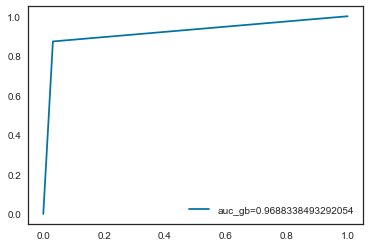

In [138]:
# Evaluations
score_gb = cross_val_score(gb_clf, X, Y, cv=5)
print(score_gb)

#Confusion matrix for logistics regression classifier
print('Confusion matrix')
print(confusion_matrix(y_test, predict_test))

# Classification report 
print(classification_report(y_test, predict_test))

# AUC
y_gb_proba = gb_clf.predict_proba(X_test)[::,1]
fpr_gb, tpr_gb, _ = metrics.roc_curve(y_test,  predict_test)
auc_gb = metrics.roc_auc_score(y_test, y_gb_proba)
plt.plot(fpr_gb,tpr_gb,label='auc_gb='+str(auc_gb))
plt.legend(loc=4)
plt.show()

In [139]:
# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.015228426395939087
Percent Type II errors: 0.06598984771573604


The model has failed to identify 13 of the fraud transactions correctly (False negatives) 

## Conclusion

Because the dataset is highly imbalanced, we have lost a lot of information while resampling to match the two classes. The remaining data is not big enough and does not represent all of the information presented in the original dataset.

The most important factor while predicting credit card fraud is to minimize the number of fraud transactions which are identified as good transactions. The vanilla logistics, and lasso clarrifiers have performed better than other models in minimizing the frauds which go undetected. 

Since the data provided is maily comprised of principal components of the original variables, it's not possible to identify factors which help understand fraud detection or get any other insight. 